In [ ]:
# Instalacion de librerias

!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy
!pip uninstall shapely -y
!pip install shapely --no-binary shapely

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libproj-dev is already the newest version (9.1.1-1~jammy0).
libproj-dev set to manually installed.
proj-data is already the newest version (9.1.1-1~jammy0).
proj-data set to manually installed.
The following NEW packages will be installed:
  proj-bin
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 197 kB of archives.
After this operation, 504 kB of additional disk space will be used.
Get:1 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 proj-bin amd64 9.1.1-1~jammy0 [197 kB]
Fetched 197 kB in 1s (171 kB/s)
Selecting previously unselected package proj-bin.
(Reading database ... 123630 files and directories currently installed.)
Preparing to unpack .../proj-bin_9.1.1-1~jammy0_amd64.deb ...
Unpacking proj-bin (9.1.1-1~jammy0) ...
Setting up proj-bin (9.1.1-1~jammy0) ...
Processing triggers for man-db (2.10.2-1) ...
Reading package lists... Don

In [ ]:
# Importacion librerias necesarias
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import imageio
import seaborn as sns


In [ ]:
# Ruta de archivo NETCDF y ruta de acceso

dir_data = '/content/'
path_acceso = dir_data + 'ulwrf.sfc.mon.mean.nc'

In [ ]:
# 1 -- Abrir el archivo y revisión de los metadatos
dataSet = xr.open_dataset(path_acceso)
dataSet['ulwrf']

<xarray.DataArray 'ulwrf' (time: 922, lat: 94, lon: 192)> Size: 67MB
[16640256 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 376B 88.54 86.65 84.75 82.85 ... -84.75 -86.65 -88.54
  * lon      (lon) float32 768B 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * time     (time) datetime64[ns] 7kB 1948-01-01 1948-02-01 ... 2024-10-01
Attributes:
    long_name:                Monthly Mean of Upward Longwave Radiation Flux
    valid_range:              [-30. 900.]
    units:                    W/m^2
    precision:                1
    least_significant_digit:  0
    var_desc:                 Upward Longwave Radiation Flux
    level_desc:               Surface
    statistic:                Mean
    parent_stat:              Individual Obs
    dataset:                  NCEP Reanalysis Derived Products
    actual_range:             [ 67.09331 564.35486]

In [ ]:
# 2 -- Selección de región asignada: 25°N-50°N y 125°W (235) -70°W (290) - Estados Unidos
# Limites latitudinales
lat_bnd = [50, 25]
# Limites longitudinales
lon_bnd = [235, 290]
# direccion guardar figuras
dir_plots = '/content/'


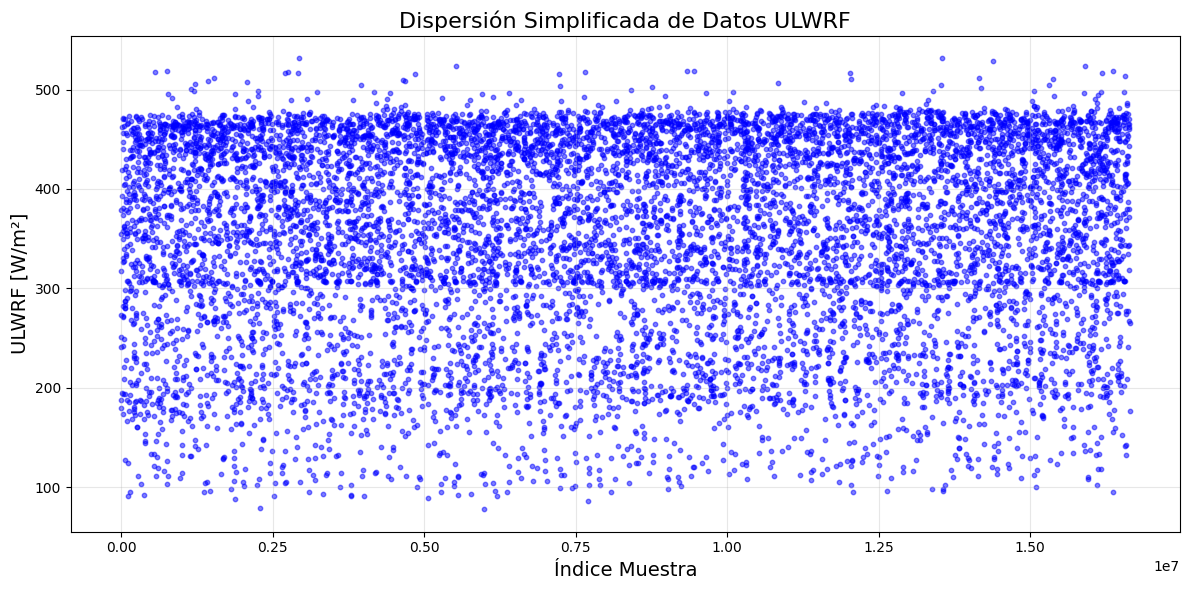

In [ ]:
# Cargar la variable ulwrf
ulwrf = dataSet['ulwrf']

# Aplanar los datos
datos_aplanados = ulwrf.values.flatten()

# Tomar una muestra aleatoria de 10,000 puntos (ajusta el número según necesidad)
np.random.seed(42)  # Fijar la semilla para reproducibilidad
muestra_indices = np.random.choice(len(datos_aplanados), size=10000, replace=False)
muestra_datos = datos_aplanados[muestra_indices]

# Crear el gráfico de dispersión
plt.figure(figsize=(12, 6))
plt.scatter(muestra_indices, muestra_datos, alpha=0.5, s=10, color='blue')
plt.title('Dispersión Simplificada de Datos ULWRF', fontsize=16)
plt.xlabel('Índice Muestra', fontsize=14)
plt.ylabel('ULWRF [W/m²]', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()

# Mostrar el gráfico
plt.savefig(dir_plots+'2_dispersión_ulwrf.png', bbox_inches='tight')
plt.show()
plt.close()

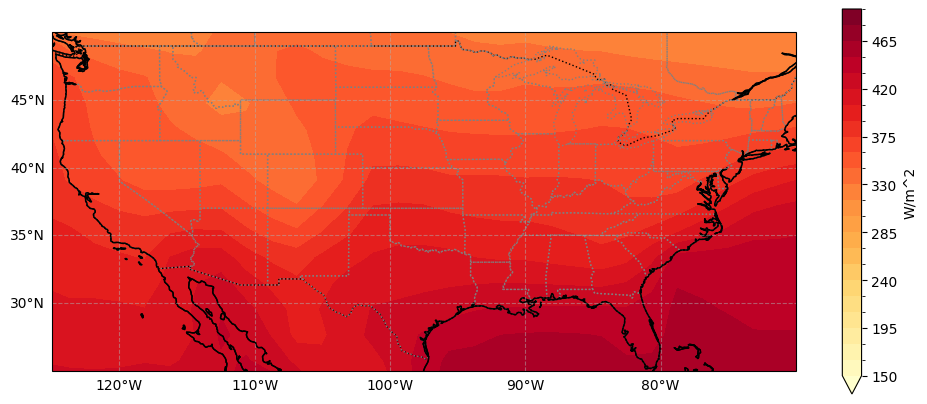

In [ ]:
# 3 -- Mapa con la climatología de la variable selecciona para dominio de interes

# Establecimiento de la figura
climatologia_ulwrf = dataSet['ulwrf'].mean('time', keep_attrs=True)
fig = plt.figure(figsize=[12,5])
ax = plt.axes(projection=ccrs.PlateCarree())
# Añadir características al mapa
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.STATES, linestyle=":", edgecolor="gray")
# Límites de la figura
ax.set_extent([235, 290, 25, 50], crs=ccrs.PlateCarree())
ax.set_title("Climatología", fontsize=14)
climatologia_ulwrf.plot.contourf(ax=ax, cmap='YlOrRd',levels=np.arange(150, 500, 15),transform=ccrs.PlateCarree(),\
                               cbar_kwargs={'label': climatologia_ulwrf.units})
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', alpha=0.5)
gl.top_labels = False  # Deshabilitar etiquetas superiores
gl.right_labels = False  # Deshabilitar etiquetas del lado derecho
gl.xlabel_style = {'size': 10, 'color': 'black'}  # Estilo para etiquetas de longitud
gl.ylabel_style = {'size': 10, 'color': 'black'}  # Estilo para etiquetas de latitud
ax.coastlines()
fig.savefig(dir_plots+'3_mapa_climatologia_ulwrf.png')
plt.show()
plt.close()


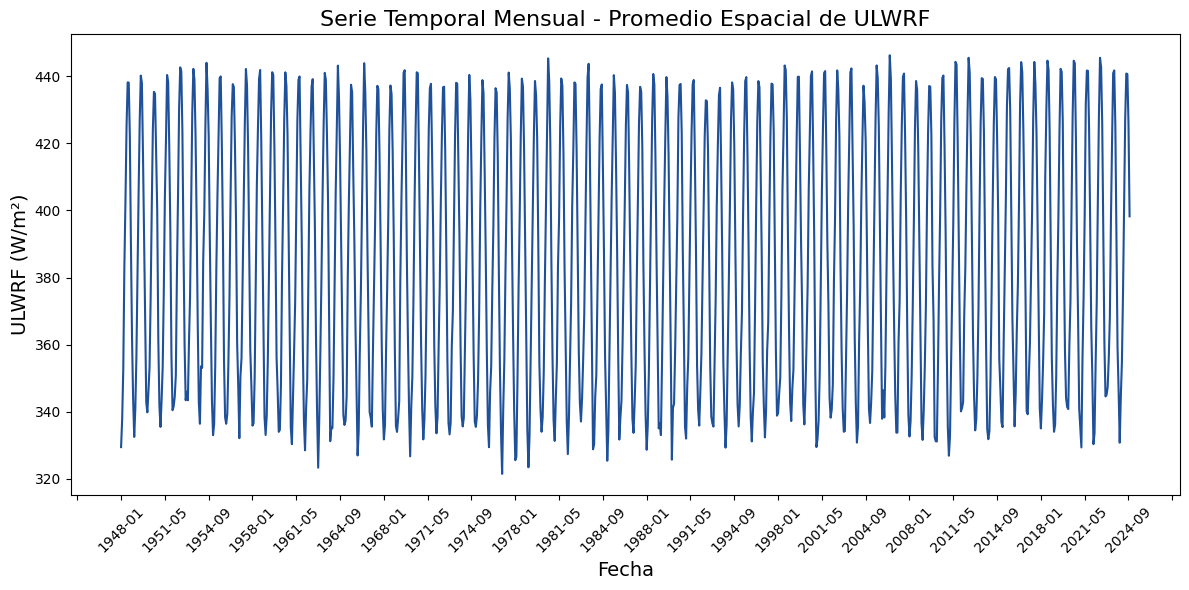

In [ ]:
# 4 -- Para la región asignada, promedio espacial de la serie
# de tiempo mensual para todo el periodo de registro de la variable. Grafico de la serie.

# Seleccionar la región de interés en la variable 'ulwrf' del dataset
ulwrf_delimitado = dataSet['ulwrf'].sel(lat=slice(50, 25), lon=slice(235, 290))

# Promediar espacialmente (en latitud y longitud) para obtener una serie temporal
ulwrf_mean_spatial = ulwrf_delimitado.mean(dim=['lat', 'lon'], skipna=True)

# Extraer valores temporales y convertirlos en un formato legible
time = ulwrf_mean_spatial.time.dt.strftime('%Y-%m').values  # Variable de tiempo, formatear las fechas como 'YYYY-MM'

# Graficar la serie temporal
plt.figure(figsize=(12, 6))
plt.plot(time, ulwrf_mean_spatial, label='Promedio Espacial de ULWRF', color='#1F509A')

# Mejoras en el gráfico
plt.title("Serie Temporal Mensual - Promedio Espacial de ULWRF", fontsize=16)
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("ULWRF (W/m²)", fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(30))  # Muestra solo 30 etiquetas principales en el eje x
plt.gca().tick_params(axis='x', rotation=45)  # Rota las etiquetas del eje x
plt.tight_layout()

plt.savefig(dir_plots+"4_promedio_espacial_serie.png")
# Mostrar el gráfico
plt.show()
plt.close()



Estadísticos descriptivos:
count    922.000000
mean     385.096130
std       38.186085
min      321.457916
25%      349.138573
50%      383.430893
75%      422.404976
max      446.287476
Name: ulwrf, dtype: float64


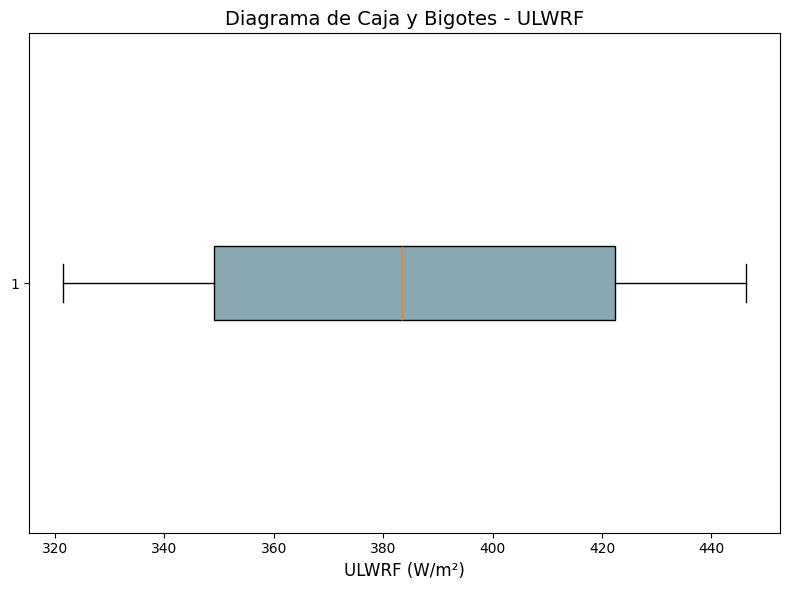

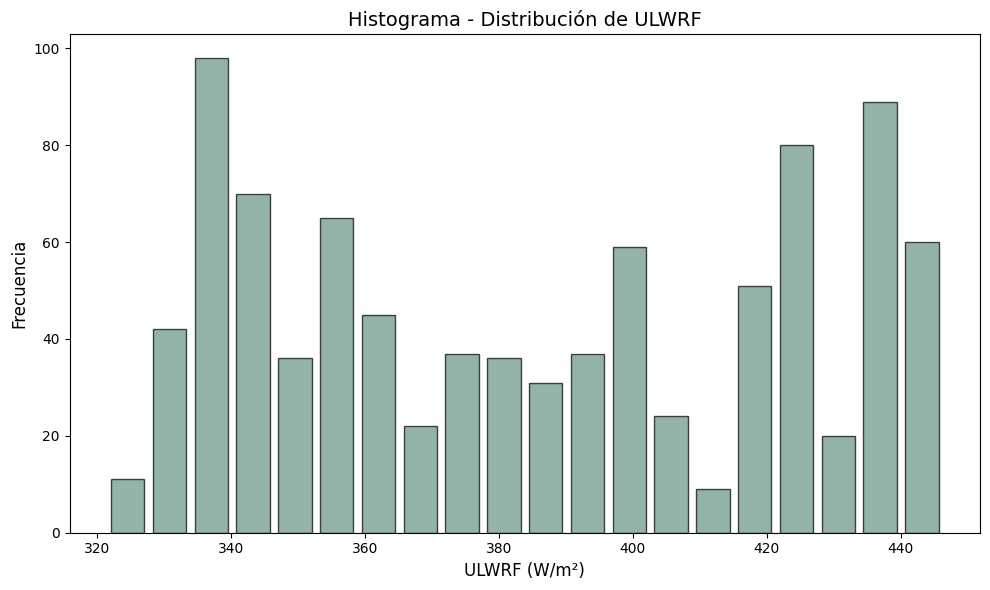

In [27]:
# 5 -- A partir de la serie de tiempo mensual, calcule estadísticos descriptivos
# básicos de los datos. Para esto puede convertir la serie de datos a un
# DataFrame de Pandas. Realice un diagrama de caja y bigotes y un
# histograma para visualizar la distribución de los datos. Analice los resultados

# Convertir ulwrf_mean_spatial a DataFrame de Pandas
dataFrame_ulwrf = ulwrf_mean_spatial.to_dataframe().reset_index()

# Estadísticos descriptivos básicos
estadisticos = dataFrame_ulwrf['ulwrf'].describe()
print("Estadísticos descriptivos:")
print(estadisticos)

# Diagrama de caja y bigotes
plt.figure(figsize=(8, 6))
plt.boxplot(dataFrame_ulwrf['ulwrf'], vert=False, patch_artist=True, boxprops=dict(facecolor='#89A8B2'))
plt.title('Diagrama de Caja y Bigotes - ULWRF', fontsize=14)
plt.xlabel('ULWRF (W/m²)', fontsize=12)
plt.tight_layout()
plt.savefig(dir_plots+"5_diagrama_caja_bigotes.png")
plt.show()

# Histograma de la distribución
plt.figure(figsize=(10, 6))
plt.hist(dataFrame_ulwrf['ulwrf'], bins=20, color='#659287', edgecolor='black', alpha=0.7, rwidth=0.8)
plt.title('Histograma - Distribución de ULWRF', fontsize=14)
plt.xlabel('ULWRF (W/m²)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.tight_layout()
plt.savefig(dir_plots+"5_histograma.png")
plt.show()

<ipython-input-25-5a21f826414c>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


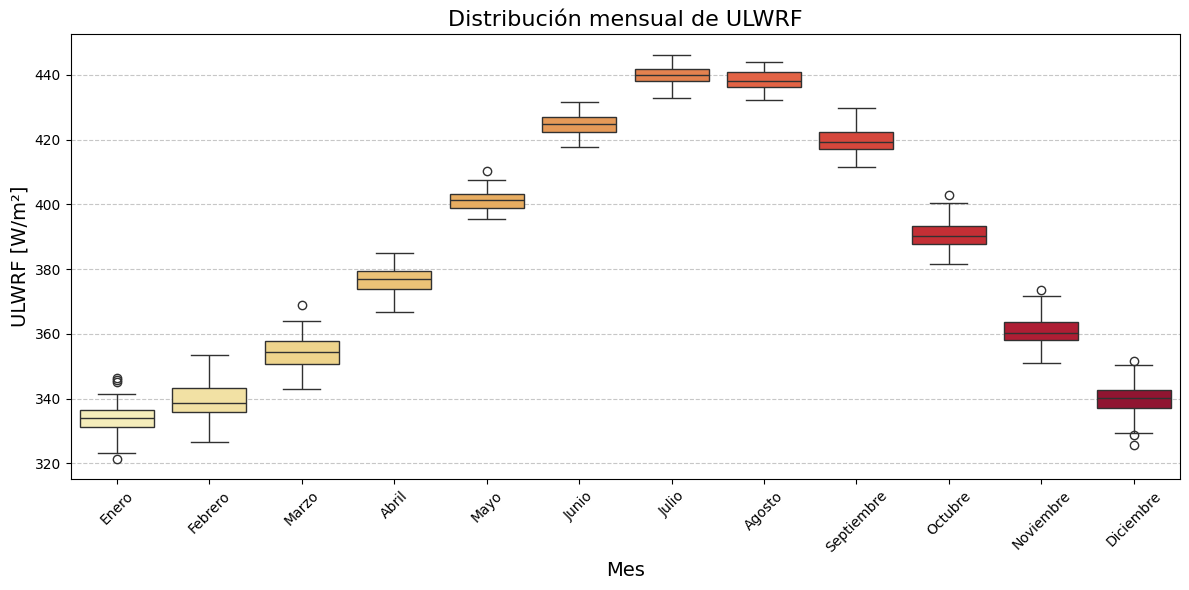

In [ ]:
# Asegurar que el DataFrame tenga una columna de mes
dataFrame_ulwrf['month'] = dataFrame_ulwrf['time'].dt.month

# Configurar el tamaño de la figura
plt.figure(figsize=(12, 6))

# Crear el boxplot para cada mes
sns.boxplot(
    x='month',
    y='ulwrf',
    data=dataFrame_ulwrf,
    palette='YlOrRd'
)

# Configurar el gráfico
plt.title('Distribución mensual de ULWRF', fontsize=16)
plt.xlabel('Mes', fontsize=14)
plt.ylabel('ULWRF [W/m²]', fontsize=14)
plt.xticks(ticks=range(12), labels=[
    'Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
    'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'
], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.tight_layout()
plt.savefig(dir_plots+"5_caja_bigotes_mes.png")
plt.show()

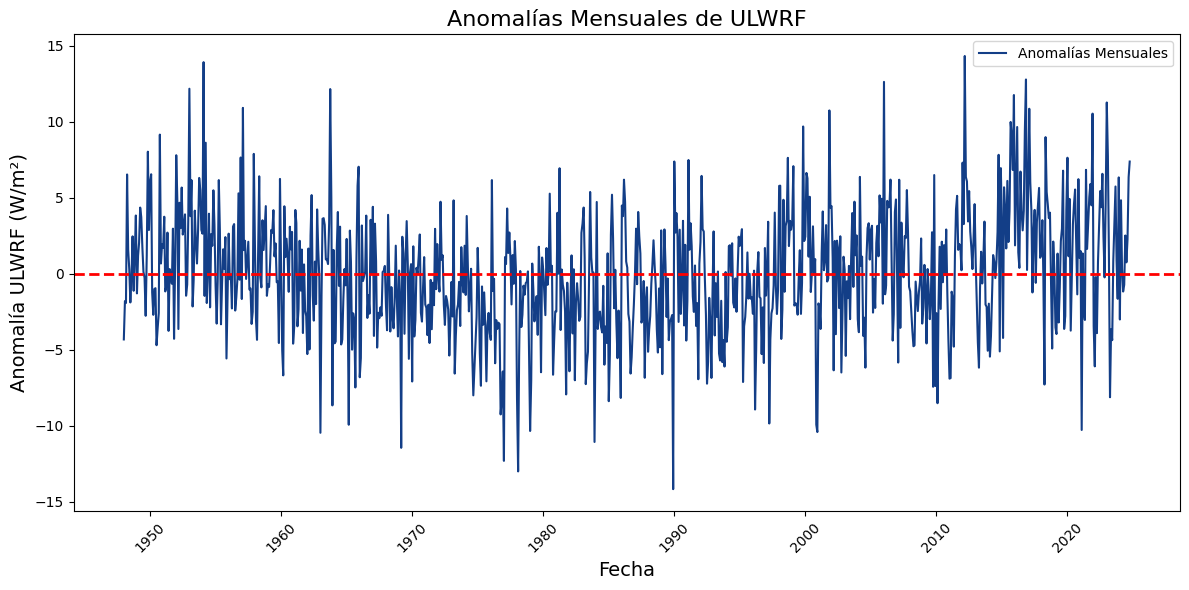

In [ ]:
# 6 -- Calcule las anomalías mensuales de la serie de tiempo de la región de interés.

# Calcular el promedio mensual histórico
promedio_mensual = ulwrf_mean_spatial.groupby('time.month').mean()

# Calcular las anomalías
anomalias_time_serie = ulwrf_mean_spatial.groupby('time.month') - promedio_mensual

# Graficar las anomalías
plt.figure(figsize=(12, 6))
plt.plot(anomalias_time_serie.time, anomalias_time_serie, label='Anomalías Mensuales', color='#133E87')
# Agregar la línea roja en el eje 0
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.title("Anomalías Mensuales de ULWRF", fontsize=16)
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("Anomalía ULWRF (W/m²)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.savefig(dir_plots+"6_anomalias_mensuales.png")
plt.show()

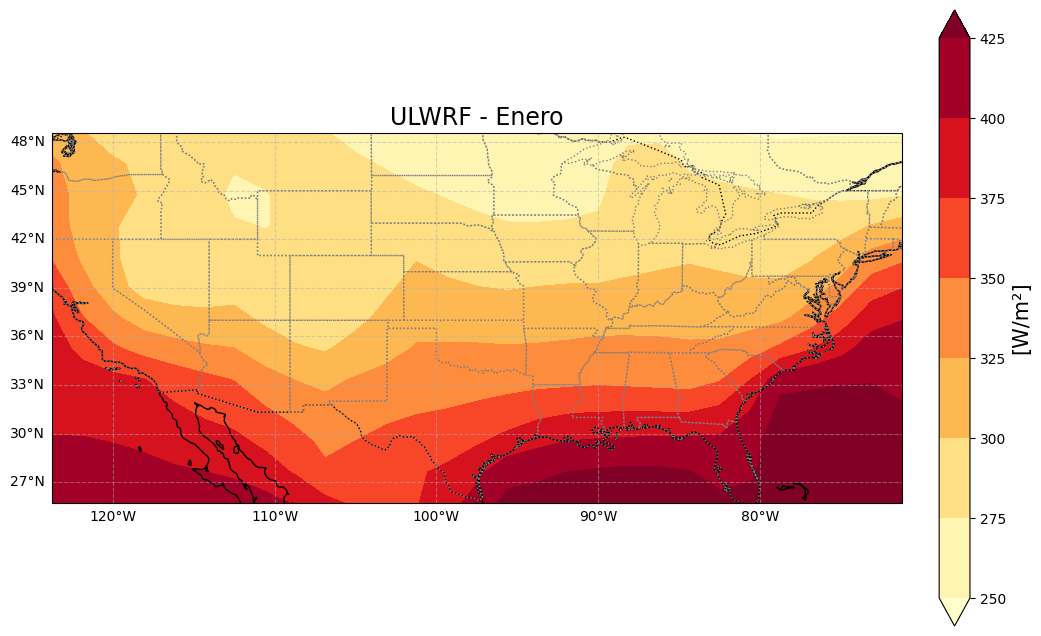

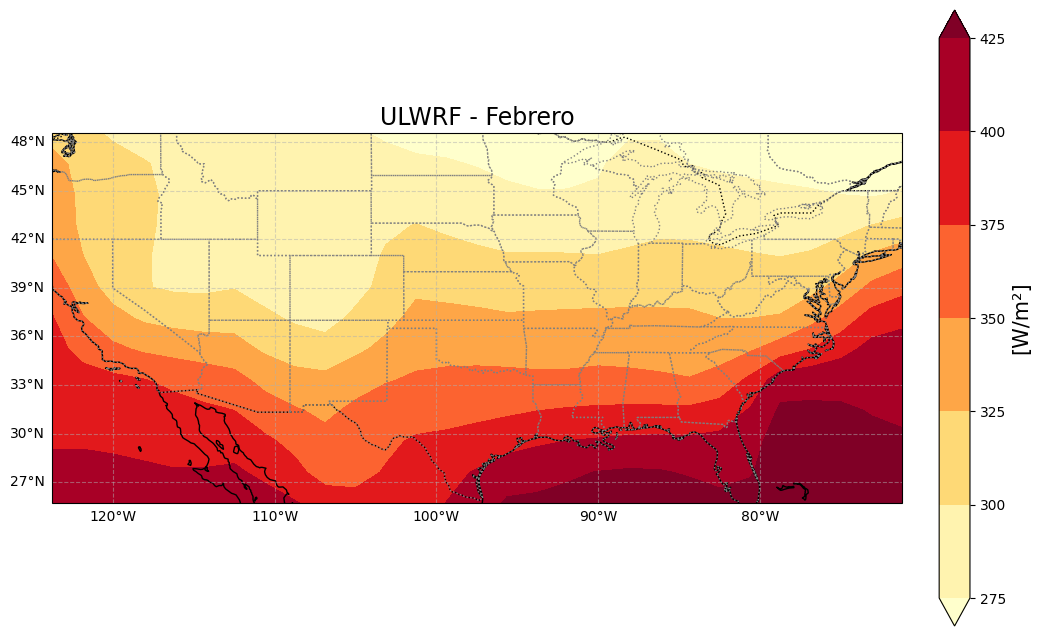

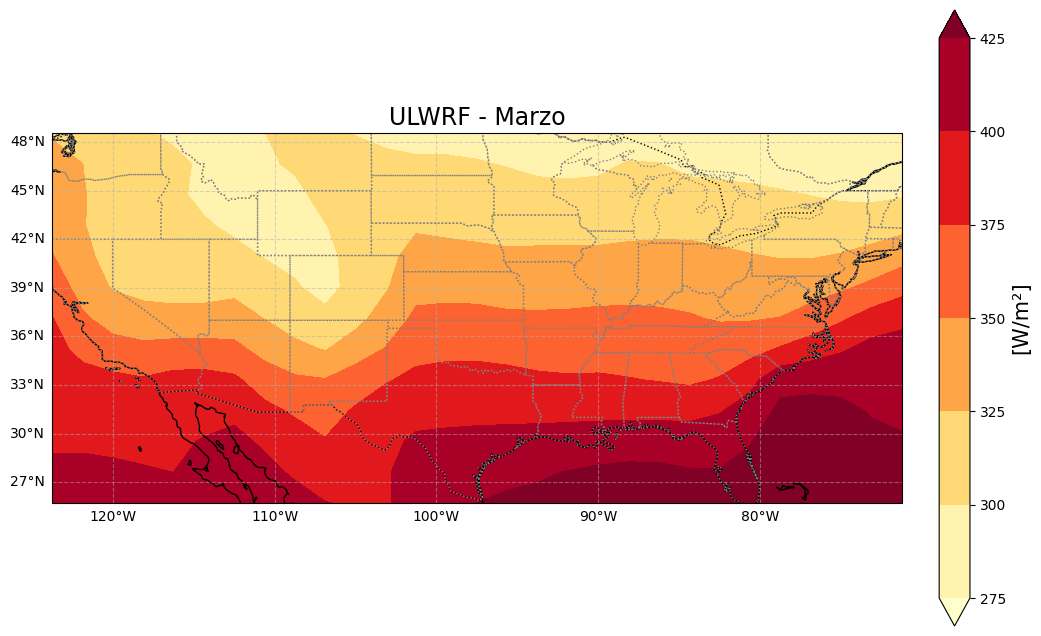

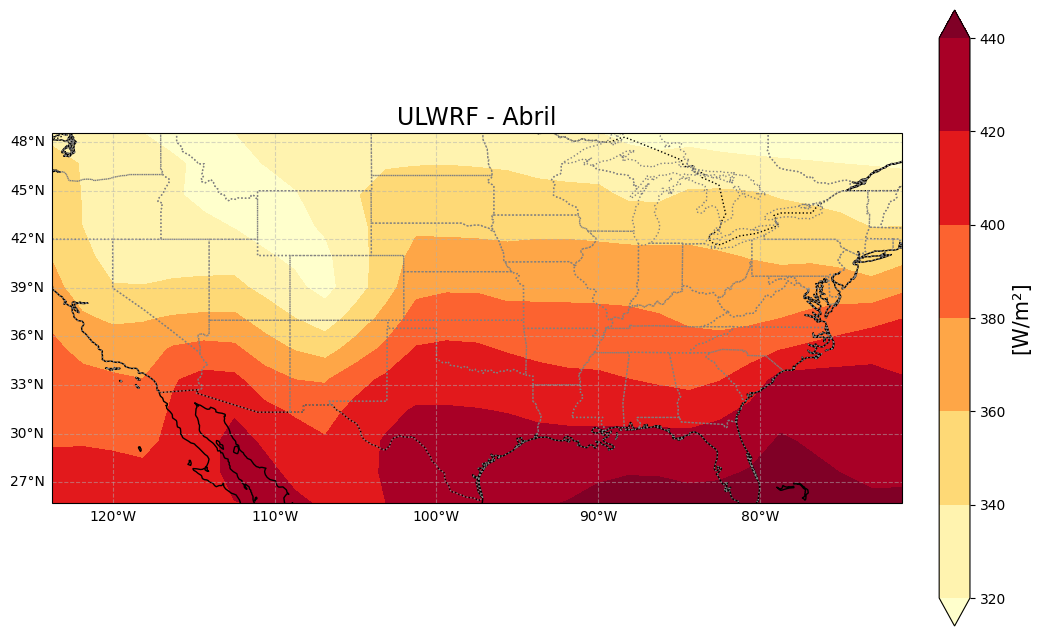

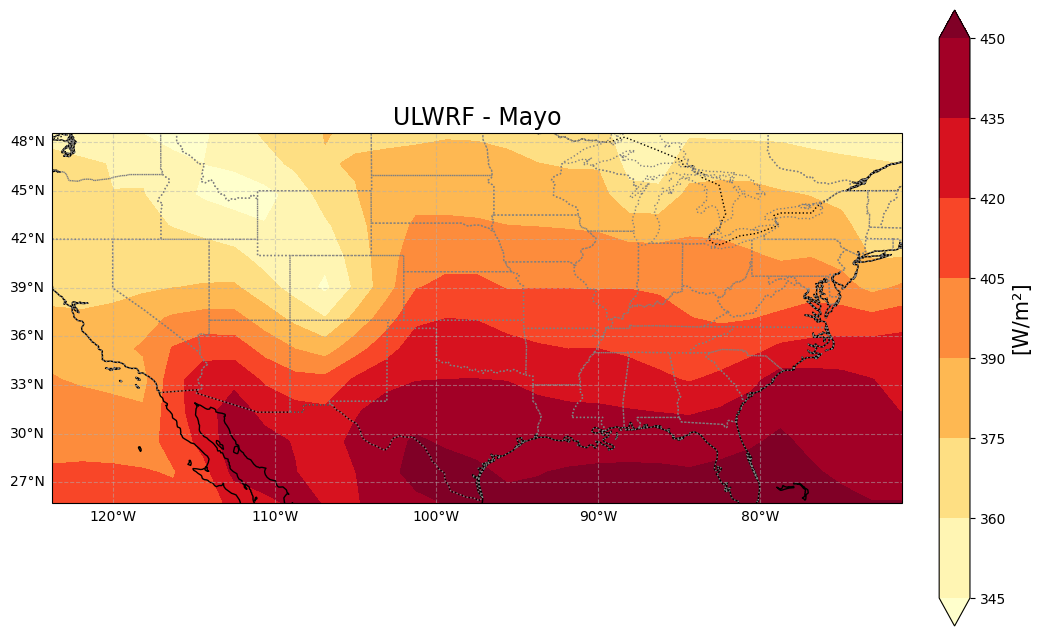

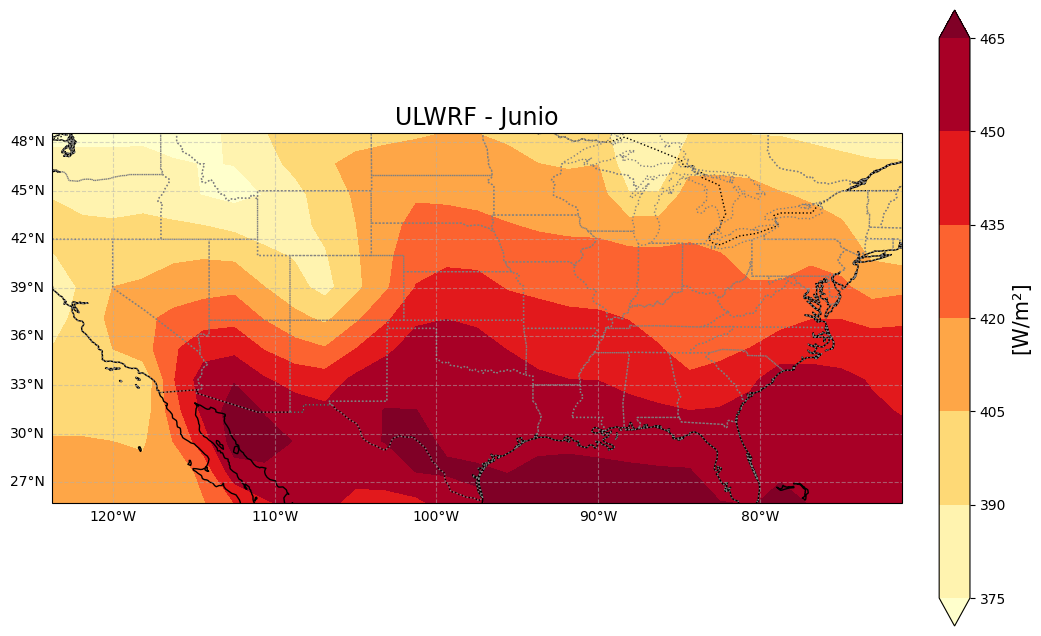

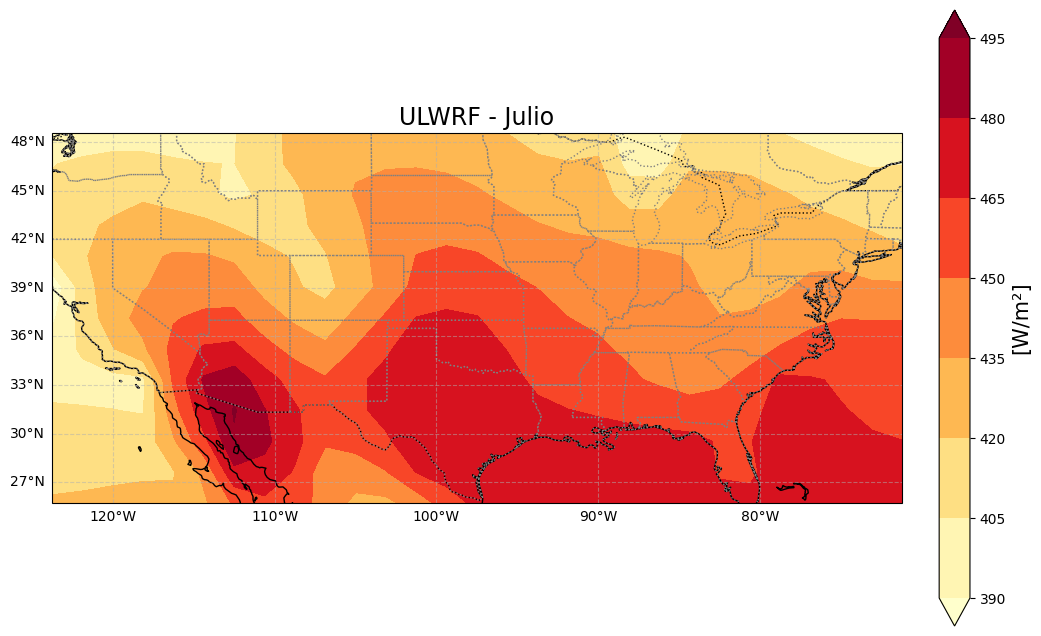

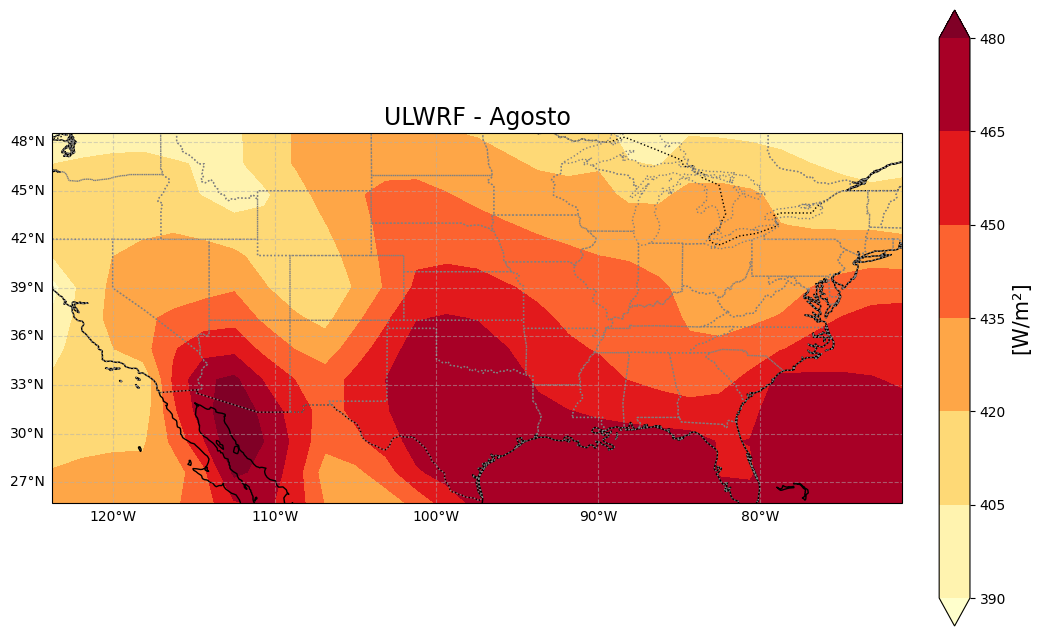

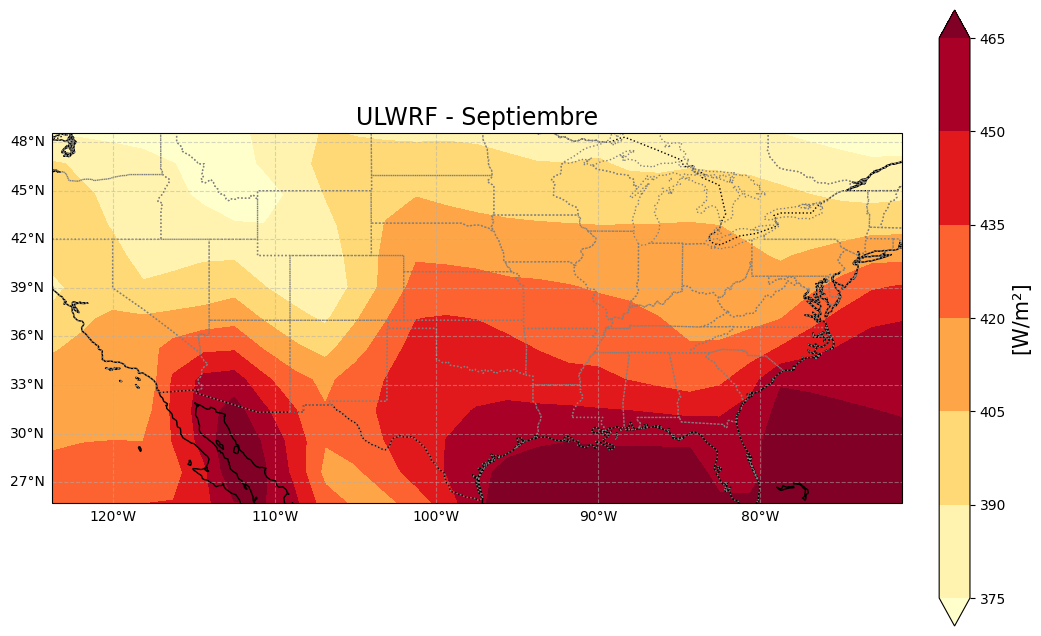

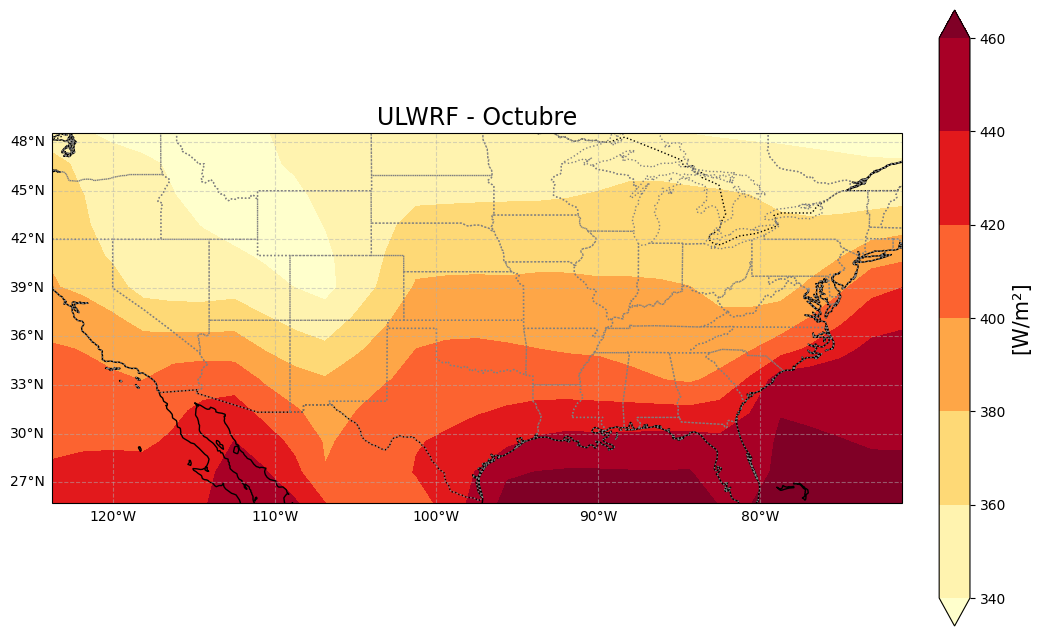

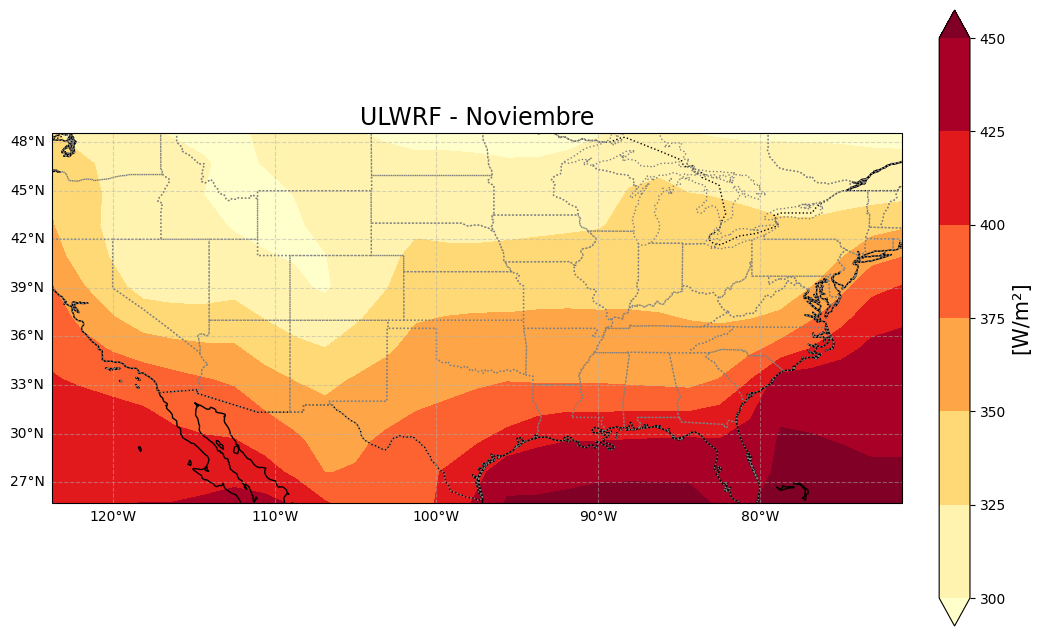

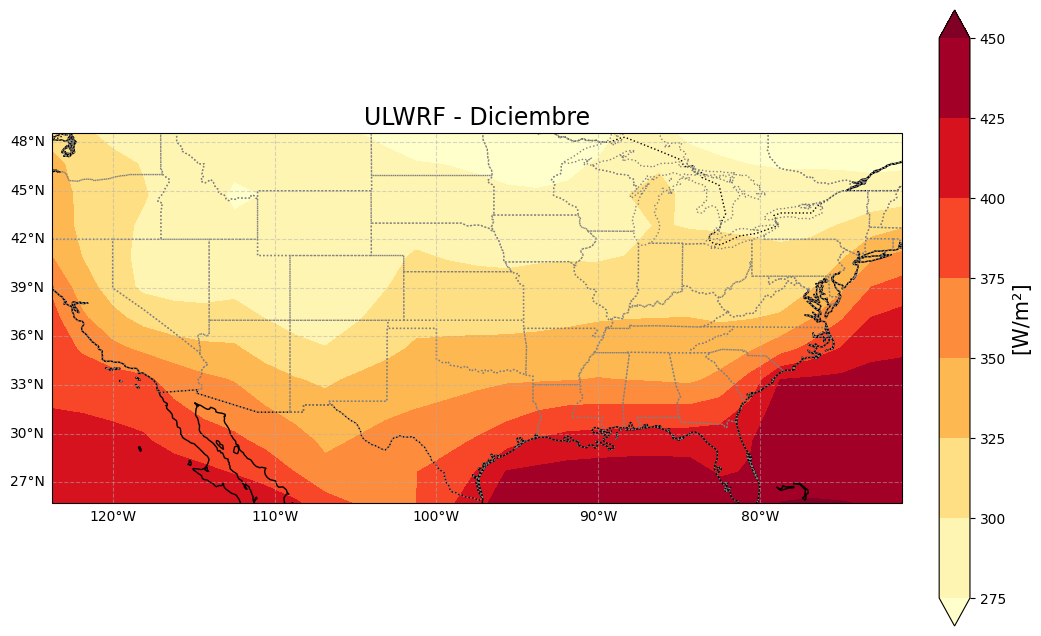

In [ ]:
# 7 -- Calcule el ciclo anual multianual de la variable seleccionada y grafique en
# mapas espaciales los patrones correspondientes a cada uno de los meses.

# Calcular el promedio mensual para cada mes en todos los años
ulwrf_monthly_cycle = ulwrf_delimitado.groupby('time.month').mean('time')

# Listado de meses para agregar el titulo a cada imagen
mes = ['Enero','Febrero','Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre']

# Lista de índices de meses para nombrar los archivos.
mes_index = ['00','01','02','03','04','05','06','07','08','09','10','11']

# Crear la malla de latitudes y longitudes para la visualización en el mapa
Lat = ulwrf_delimitado.coords['lat'].values  # Latitudes
Lon = ulwrf_delimitado.coords['lon'].values  # Longitudes
lon2D, lat2D = np.meshgrid(Lon, Lat)  # Crear malla 2D de lon y lat

# Se crea la matriz de las latitudes y longitudes y el extent del mapa
lon2D, lat2D = np.meshgrid(Lon, Lat)
projection = ccrs.PlateCarree() # Definiendo la proyeccion
extent = [min(Lon),max(Lon),min(Lat),max(Lat)]

ulwrf_monthly_cycle_array = np.array(ulwrf_monthly_cycle)
# Ciclo For para iterar sobre los meses y generar 12 imágenes (una para cada mes)
for i in range(12):

    # Selección de datos
    month_data = ulwrf_monthly_cycle.isel(month=i).values  # Extrae los datos del mes

    # Crear figura
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_title(f'ULWRF - {mes[i]}', fontsize=17)
    ax.set_extent(extent, crs=ccrs.PlateCarree())  # Define la región de interés

    # Graficar datos
    pp = ax.contourf(lon2D, lat2D, month_data, cmap='YlOrRd', extend='both', transform=ccrs.PlateCarree())

    # Añadir características geográficas
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle=":", edgecolor="gray")
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', alpha=0.5)
    gl.top_labels = False  # Deshabilitar etiquetas superiores
    gl.right_labels = False  # Deshabilitar etiquetas del lado derecho
    gl.xlabel_style = {'size': 10, 'color': 'black'}  # Estilo para etiquetas de longitud
    gl.ylabel_style = {'size': 10, 'color': 'black'}  # Estilo para etiquetas de latitud

    # Barra de color
    cb = plt.colorbar(pp, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cb.set_label('[W/m²]', fontsize=15)

    # Guardar figura
    fig.savefig(f'{dir_plots}{mes_index[i]}_{mes[i]}_ULWRF.png', format='png', bbox_inches='tight')
    plt.show()
    plt.close()


In [ ]:
# Generar animación
imagenes = []
archivos = ['00_Enero_ULWRF.png','01_Febrero_ULWRF.png','02_Marzo_ULWRF.png',\
            '03_Abril_ULWRF.png','04_Mayo_ULWRF.png','05_Junio_ULWRF.png',\
            '06_Julio_ULWRF.png', '07_Agosto_ULWRF.png', '08_Septiembre_ULWRF.png',\
            '09_Octubre_ULWRF.png', '10_Noviembre_ULWRF.png', '11_Diciembre_ULWRF.png']
# Ciclo para leer la información de cada imagen
for nombres in archivos:
  # Lectura de imagenes que queremos unir en el gif
  imagenes.append(imageio.imread(dir_plots+nombres))

imageio.mimsave(dir_plots+'7_ciclo_multianual.gif',imagenes,duration=1)


<ipython-input-17-04325e32594a>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imagenes.append(imageio.imread(dir_plots+nombres))


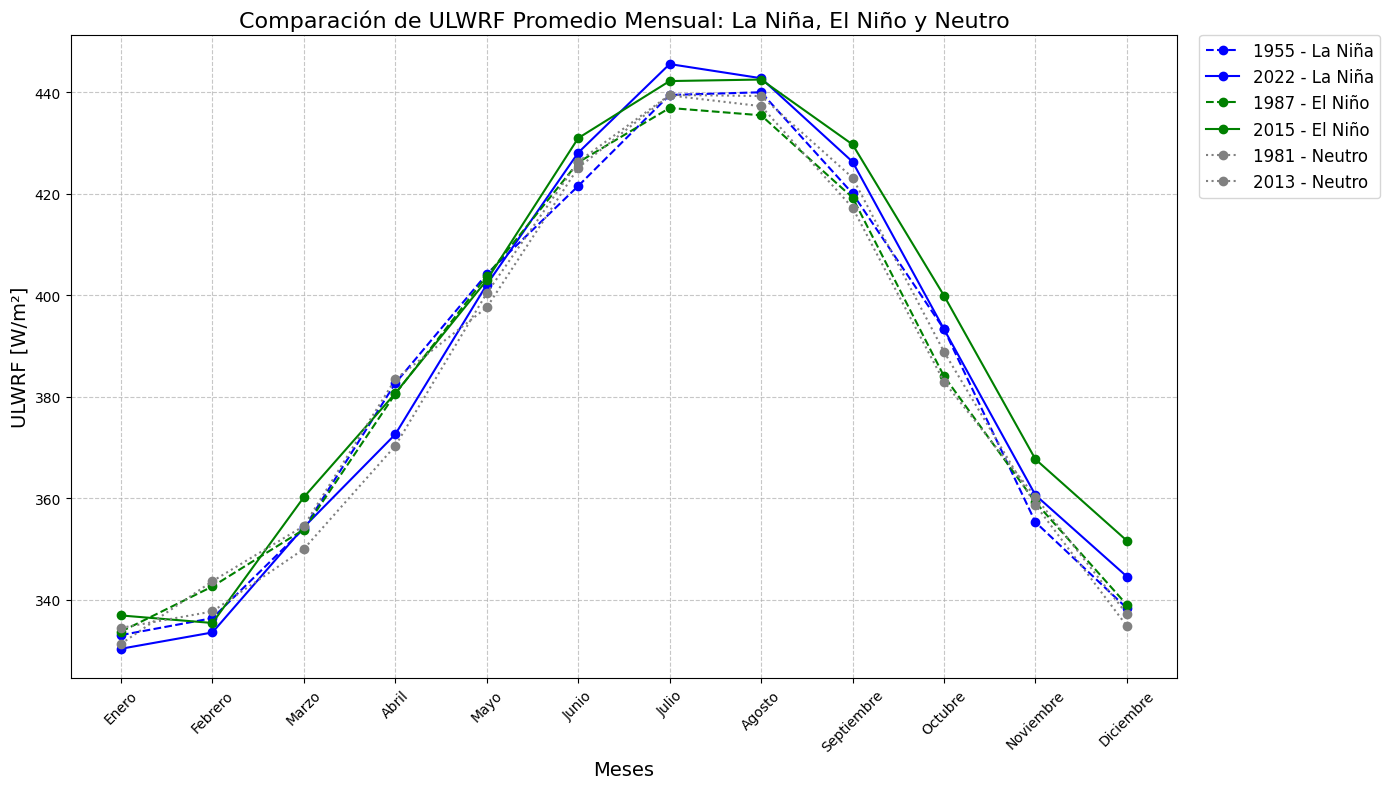

In [ ]:
# 8 -- Seleccione los periodos El Niño, La Niña y neutros de la serie de tiempo para
# la región de interés y compare los patrones de la variable en cada uno de los
# casos (si la variable aumenta, disminuye o se mantiene en condiciones
# normales bajo eventos El Niño, La Niña y neutrales). Realice gráficas que
# oporten los análisis

# 1955	-0.7	-0.6	-0.7	-0.8	-0.8	-0.7	-0.7	-0.7	-1.1	-1.4	-1.7	-1.5 - NIÑA
# 2022	-1.0	-0.9	-1.0	-1.1	-1.0	-0.9	-0.8	-0.9	-1.0	-1.0	-0.9	-0.8 - NIÑA
# 1987	1.2	1.2	1.1	0.9	1.0	1.2	1.5	1.7	1.6	1.5	1.3	1.1 - NIÑO
# 2015	0.5	0.5	0.5	0.7	0.9	1.2	1.5	1.9	2.2	2.4	2.6	2.6 - NIÑO
# 1981	-0.3	-0.5	-0.5	-0.4	-0.3	-0.3	-0.3	-0.2	-0.2	-0.1	-0.2	-0.1 - NEUTRO
# 2013	-0.4	-0.4	-0.3	-0.3	-0.4	-0.4	-0.4	-0.3	-0.3	-0.2	-0.2	-0.3 - NEUTRO

# Extraccion datos de los años de interes
datos_1955_nina = ulwrf_delimitado.where(ulwrf_delimitado['time'].dt.year == 1955, drop=True)

datos_2022_nina = ulwrf_delimitado.where(ulwrf_delimitado['time'].dt.year == 2022, drop=True)

datos_1987_nino = ulwrf_delimitado.where(ulwrf_delimitado['time'].dt.year == 1987, drop=True)

datos_2015_nino = ulwrf_delimitado.where(ulwrf_delimitado['time'].dt.year == 2015, drop=True)

datos_1981_neutro = ulwrf_delimitado.where(ulwrf_delimitado['time'].dt.year == 1981, drop=True)

datos_2013_neutro = ulwrf_delimitado.where(ulwrf_delimitado['time'].dt.year == 2013, drop=True)

# Calcular el promedio mensual para cada conjunto de datos
promedios = {
    "1955 - La Niña": datos_1955_nina.groupby('time.month').mean(['lat', 'lon']),
    "2022 - La Niña": datos_2022_nina.groupby('time.month').mean(['lat', 'lon']),
    "1987 - El Niño": datos_1987_nino.groupby('time.month').mean(['lat', 'lon']),
    "2015 - El Niño": datos_2015_nino.groupby('time.month').mean(['lat', 'lon']),
    "1981 - Neutro": datos_1981_neutro.groupby('time.month').mean(['lat', 'lon']),
    "2013 - Neutro": datos_2013_neutro.groupby('time.month').mean(['lat', 'lon']),
}

# Crear el gráfico
fig, ax = plt.subplots(figsize=(14, 8))

# Colores y estilos de línea para cada conjunto de datos
estilos = ['dashed', 'solid', 'dashed', 'solid', 'dotted', 'dotted']
colores = ['blue', 'blue', 'green', 'green', 'gray', 'gray']

for (label, data), color, estilo in zip(promedios.items(), colores, estilos):
    ax.plot(
        mes,
        data.values.flatten(),
        label=label,
        color=color,
        linestyle=estilo,
        marker='o'
    )

# Configuración del gráfico
ax.set_ylabel('ULWRF [W/m²]', fontsize=14)
ax.set_xlabel('Meses', fontsize=14)
ax.set_xticks(range(12))
ax.set_xticklabels(mes, rotation=45)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(loc='upper left', fontsize=12, bbox_to_anchor=(1.02, 1), borderaxespad=0)

# Título del gráfico
plt.title('Comparación de ULWRF Promedio Mensual: La Niña, El Niño y Neutro', fontsize=16)

# Ajustar diseño para evitar superposición
plt.tight_layout()
plt.savefig(dir_plots+"8_anomalias_climaticas.png")
# Mostrar el gráfico
plt.show()
plt.close()

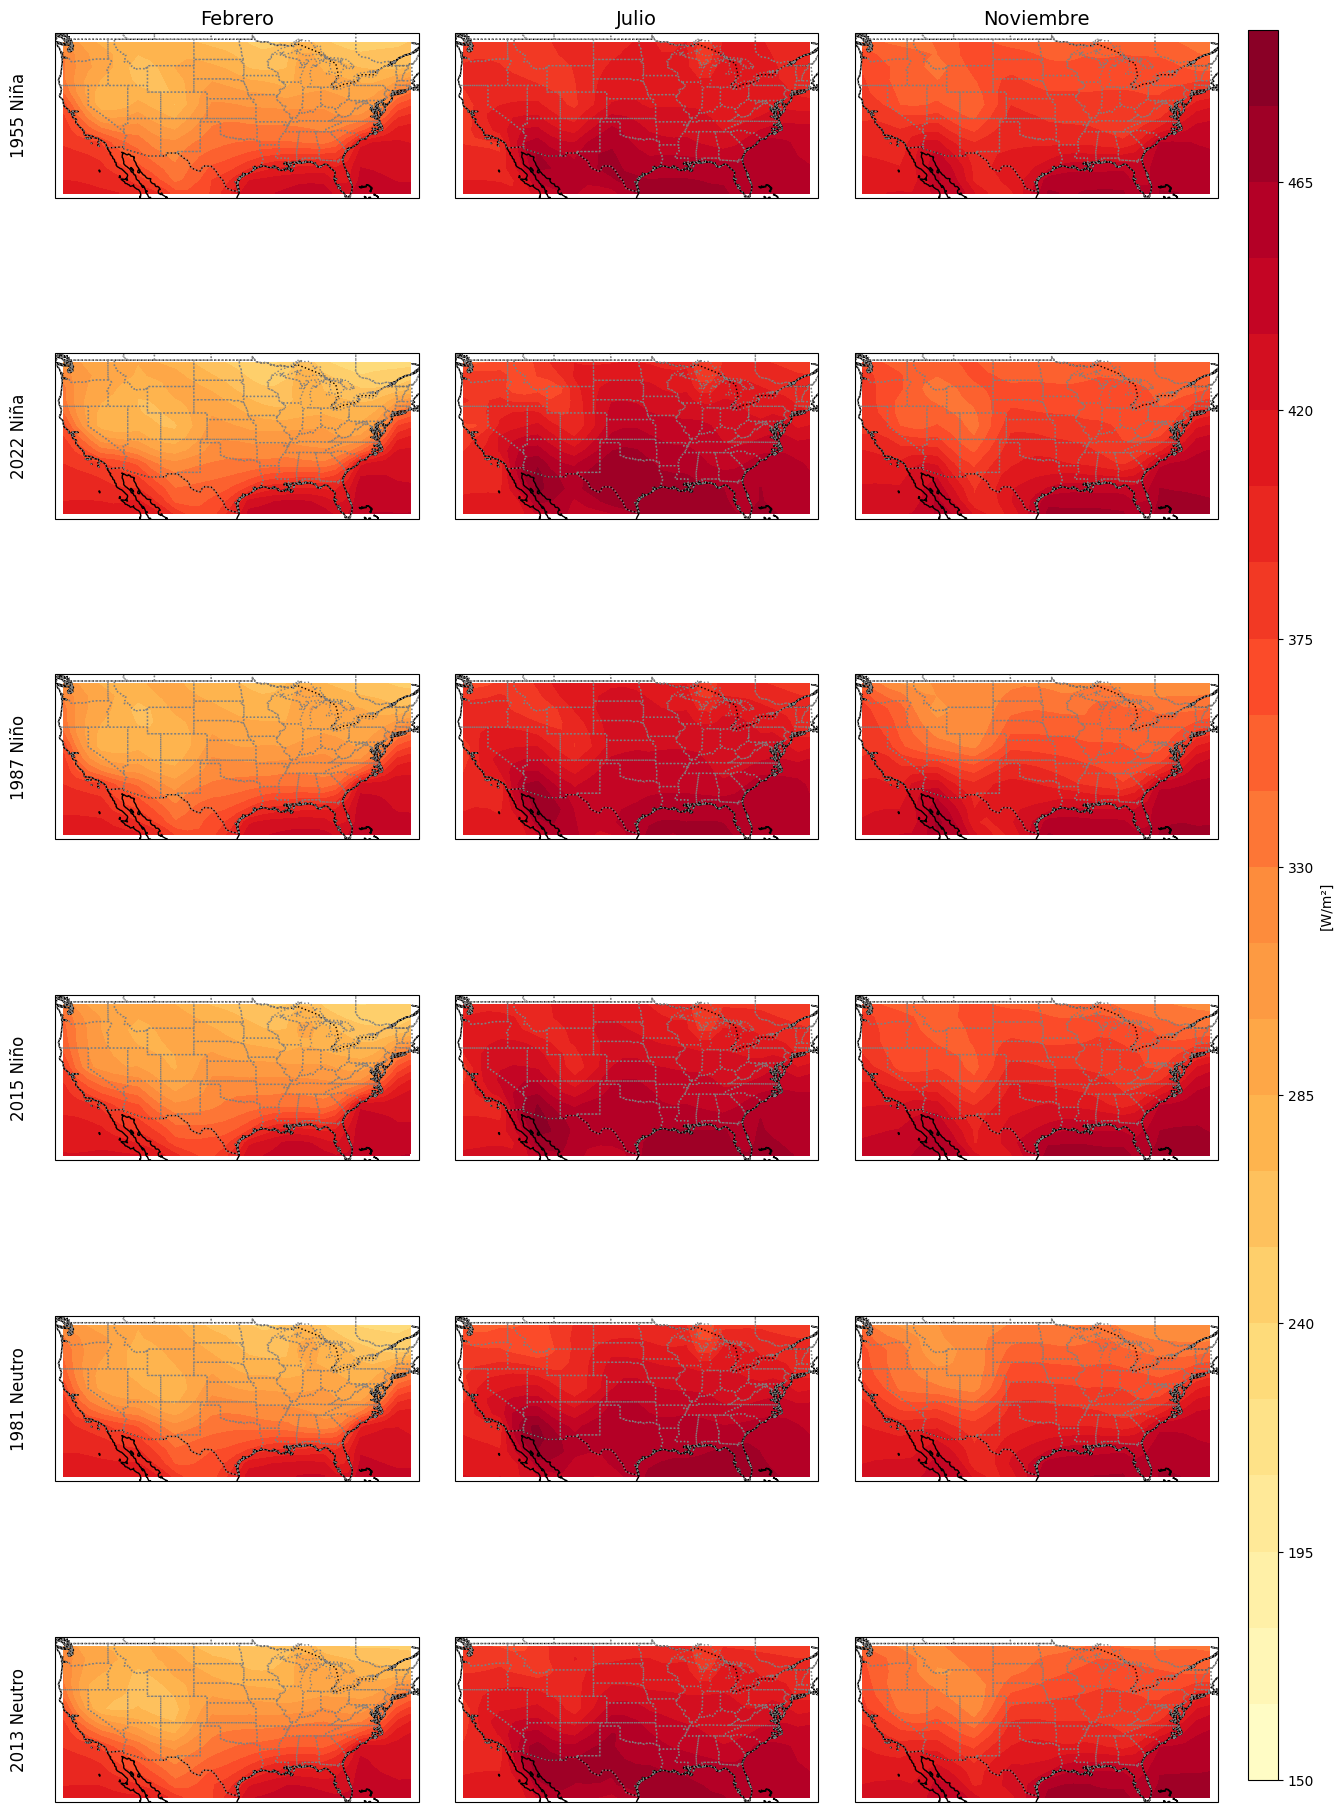

In [ ]:
# Crear una lista con las variables de los años
variables = [datos_1955_nina, datos_2022_nina, datos_1987_nino, datos_2015_nino, datos_1981_neutro, datos_2013_neutro]
nombres = ['1955 Niña', '2022 Niña', '1987 Niño', '2015 Niño', '1981 Neutro', '2013 Neutro']

# Seleccionar los meses: febrero (índice 1), julio (índice 6), noviembre (índice 10)
meses = [1, 6, 10]  # Índices de los meses en la dimensión 'time'
mes_nombres = ['Febrero', 'Julio', 'Noviembre']

# Crear el tamaño de la figura
fig, axes = plt.subplots(6, 3, figsize=(15, 25), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=0.0002, wspace=0.1)

# Extensión de los mapas
extent = [235, 290, 25, 50]

# Crear los subgráficos
for i, variable in enumerate(variables):  # Iterar sobre las variables (filas)
    for j, mes in enumerate(meses):  # Iterar sobre los meses (columnas)
        ax = axes[i, j]
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.STATES, linestyle=":", edgecolor="gray")

        # Extraer el promedio del mes específico
        datos_mes = variable.sel(time=variable['time.month'] == mes).mean('time')

        # Graficar los datos
        im = ax.contourf(
            datos_mes['lon'],
            datos_mes['lat'],
            datos_mes,
            cmap='YlOrRd',
            levels=np.arange(150, 500, 15),
            transform=ccrs.PlateCarree()
        )

        # Títulos para los mapas
        if i == 0:  # Primera fila (encabezado de las columnas)
            ax.set_title(mes_nombres[j], fontsize=14)
        if j == 0:  # Primera columna (etiquetas de las filas)
            ax.text(
                -0.1, 0.5, nombres[i], va='center', ha='center',
                rotation='vertical', fontsize=12, transform=ax.transAxes
            )

# Agregar barra de color
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, label='[W/m²]')

# Guardar la figura
fig.savefig(dir_plots + '8_mapas_subgraficos.png', bbox_inches='tight')
plt.show()
plt.close()